In [1]:
from surgery_utils import surgery_preprocess, split, get_scores, plot_scores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score,train_test_split,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_curve, auc

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from hyperopt import Trials, fmin, tpe, anneal, space_eval, hp
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
surgery = surgery_preprocess(split=False)
ros = RandomOverSampler()
kf = StratifiedKFold()
surgery.columns

Index(['FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'Smoking', 'Age',
       'Risk1Yr', 'FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2', '_DGN2', '_DGN3', '_DGN4',
       '_DGN5'],
      dtype='object')

Our baseline model will be a logistic regression without any hyperparameter tuning, engineered features, or upsampling

In [3]:
lr_baseline = LogisticRegression()
engineered_feats = ['FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2']
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']
baseline_scores = {}
for s in scores:
    baseline_scores['validation_'+s] = np.zeros(30)
    baseline_scores['test_'+s] = np.zeros(30)
for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery, drop_cols=engineered_feats)
    model_scores = get_scores(lr_baseline, X_train, X_test, 
                             y_train, y_test, scores)
    for s in scores:
        baseline_scores['validation_'+s][i] = model_scores['validation_'+s]
        baseline_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean validation_{s}: {baseline_scores["validation_"+s].mean()}')
    print(f'Mean test_{s}: {baseline_scores["test_"+s].mean()}')

Mean validation_roc_auc_score: 0.7640115440115438
Mean test_roc_auc_score: 0.6780289330922245
Mean validation_recall_score: 0.050303030303030294
Mean test_recall_score: 0.021428571428571425
Mean validation_accuracy_score: 0.8485585585585584
Mean test_accuracy_score: 0.8315412186379929
Mean validation_average_precision_score: 0.16381293681293682
Mean test_average_precision_score: 0.15830389144905274


A Logistic Regression model after feature engineering, but without upsampling or tuning:

In [4]:
lr_engineering = LogisticRegression()
engineering_scores = {}
for s in scores:
    engineering_scores['validation_'+s] = np.zeros(30)
    engineering_scores['test_'+s] = np.zeros(30)
for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery)
    model_scores = get_scores(lr_engineering, X_train, X_test, 
                             y_train, y_test, scores)   
    for s in scores:
        engineering_scores['validation_'+s][i] = model_scores['validation_'+s]
        engineering_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean validation_{s}: {engineering_scores["validation_"+s].mean()}')
    print(f'Mean test_{s}: {engineering_scores["test_"+s].mean()}')

Mean validation_roc_auc_score: 0.7749591149591151
Mean test_roc_auc_score: 0.6565099457504521
Mean validation_recall_score: 0.060000000000000005
Mean test_recall_score: 0.03095238095238095
Mean validation_accuracy_score: 0.8507207207207207
Mean test_accuracy_score: 0.8301075268817204
Mean validation_average_precision_score: 0.17101358560449467
Mean test_average_precision_score: 0.15954877112135174


We actually see a drop in AUC, indicated that our engineered features are overfitting. We therefore drop some of them:

In [5]:
to_drop = {'set_1': ['FVC*FEV1','FVC^2*FEV1','FVC*FEV1^2'],
           'set_2': ['FVC_deficit','FEV1_deficit','FEV1/FVC_deficit'],
           'set_3': ['FVC*FEV1','FVC^2*FEV1','FVC*FEV1^2','FVC_deficit','FEV1_deficit',
            'FEV1/FVC_deficit'],
           'set_4': ['FVC*FEV1','FVC^2','FEV1^2'],
           'set_5': ['FVC*FEV1','FVC^2','FEV1^2','FVC^2*FEV1','FVC*FEV1^2']}
selection_results = {}

for k in to_drop.keys():
    engineering_scores = {}
    for s in scores:
        engineering_scores['validation_'+s] = np.zeros(30)
        engineering_scores['test_'+s] = np.zeros(30)

    for i in range(30):
        X_train, X_test, y_train, y_test = split(surgery,drop_cols=to_drop[k])
        model_scores = get_scores(lr_engineering, X_train, X_test, 
                                 y_train, y_test, scores)   
        for s in scores:
            engineering_scores['validation_'+s][i] = model_scores['validation_'+s]
            engineering_scores['test_'+s][i] = model_scores['test_'+s]
    selection_results[k] = engineering_scores

In [6]:
for k in selection_results.keys():
    print(f'{k} mean scores:')
    for s in scores:
        print(f'validation_{s}: {selection_results[k]["validation_"+s].mean()}')
        print(f'test_{s}: {selection_results[k]["test_"+s].mean()}')
    print('')

set_1 mean scores:
validation_roc_auc_score: 0.777015873015873
test_roc_auc_score: 0.6577456298975286
validation_recall_score: 0.05575757575757574
test_recall_score: 0.04285714285714285
validation_accuracy_score: 0.8508108108108108
test_accuracy_score: 0.836200716845878
validation_average_precision_score: 0.1701706056706057
test_average_precision_score: 0.16844388586324074

set_2 mean scores:
validation_roc_auc_score: 0.7662645502645503
test_roc_auc_score: 0.6957504520795659
validation_recall_score: 0.049090909090909074
test_recall_score: 0.030952380952380946
validation_accuracy_score: 0.8499099099099098
test_accuracy_score: 0.8376344086021505
validation_average_precision_score: 0.16556257615348524
test_average_precision_score: 0.161036866359447

set_3 mean scores:
validation_roc_auc_score: 0.7713169793169794
test_roc_auc_score: 0.6588607594936707
validation_recall_score: 0.05696969696969696
test_recall_score: 0.021428571428571425
validation_accuracy_score: 0.851171171171171
test_accur

Prior analyses showed that the results of our models are heavily dependent on the intial train/test split. We will therefore run multiple trials with this split as the start point and average the results.

In [7]:
def build_model(model, params, obj, scores, data, k=3, evals=4, scoring='roc_auc',
                drop=[], return_idx=False, return_roc=False, **model_args):
    scores_dict={}
    param_list=[]
    if return_idx:
        idx_list = []
    if return_roc:
        roc_dict = {}
        
    for s in scores:
        scores_dict['validation_'+s] = np.zeros(k)
        scores_dict['test_'+s] = np.zeros(k)
    for i in range(k):
        X_train, X_test, y_train, y_test = split(data, drop_cols=drop)
        mod = model(**model_args)
        pipe = Pipeline([('upsample',ros),('model',mod)])
        trials = Trials()
        # Partial make its own callable function. When you call partial() you supply
        # a function with n args and supply k of them. Then, when you call the function
        # that partial creates, you supply the remaining n-k. These n-k serve as the
        # FIRST arguments to the function of which you made a partial
        fmin_func = partial(obj, pipe=pipe, train_X=X_train, train_y=y_train,
                            scoring=scoring)
        best = fmin(fn=fmin_func, 
                    space=params, algo=anneal.suggest, max_evals=evals,
                    trials=trials)
        best_params = space_eval(params,best)
        
        pipe.fit(X_train,y_train)
        pipe.set_params(**best_params)
        model_scores = get_scores(pipe, X_train, X_test, y_train, y_test,
                                  scores)
        for s in scores:
            scores_dict['validation_'+s][i] = model_scores['validation_'+s]
            scores_dict['test_'+s][i] = model_scores['test_'+s]
        param_list.append(best_params)
        if return_idx:
            idx_list.append(X_train.index)
        if return_roc:
            probs_v = pipe.predict_proba(X_train)[:,1]
            probs_t = pipe.predict_proba(X_test)[:,1]   
            fpr_v, tpr_v, threshold_v = roc_curve(y_train, probs_v)
            fpr_t, tpr_t, threshold_t = roc_curve(y_test, probs_t)
            roc_dict['run'+str(i)+'_validation_fpr'] = fpr_v
            roc_dict['run'+str(i)+'_validation_tpr'] = tpr_v
            roc_dict['run'+str(i)+'_test_fpr'] = fpr_t            
            roc_dict['run'+str(i)+'_test_tpr'] = tpr_t
    if return_idx:
        if return_roc:
            return scores_dict, param_list, idx_list, roc_dict
        return scores_dict, param_list, idx_list
    if return_roc:
        scores_dict, param_list, roc_dict
    return scores_dict, param_list

In [8]:
# Function to plot ROC curves of one model, from k different train/test splits
# model_name = Name of the model
# roc_dict = from build_model, return_roc=True
# nruns = from build_model, k
# colors = ['color1','color2',...,'colork']
def plot_auroc(model_name,roc_dict,nruns,colors=None):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    if not colors:
        colors = np.random.random(size=(nruns,3))        
    axs[0].set_title(model_name.title()+' Validation ROC Curves')
    axs[1].set_title(model_name.title()+' Test ROC Curves')
    for i in range(nruns):
        axs[0].plot(roc_dict['run'+str(i)+'_validation_fpr'], roc_dict['run'+str(i)+'_validation_tpr'], c=colors[i], 
                 label = 'Run '+str(i)+' AUC = %0.2f' % auc(roc_dict['run'+str(i)+'_validation_fpr'], roc_dict['run'+str(i)+'_validation_tpr']))
        axs[1].plot(roc_dict['run'+str(i)+'_test_fpr'], roc_dict['run'+str(i)+'_test_tpr'], c=colors[i], 
                 label = 'Run '+str(i)+' AUC = %0.2f' % auc(roc_dict['run'+str(i)+'_test_fpr'], roc_dict['run'+str(i)+'_test_tpr']))
    for ax in axs.flat:
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1.0])
        ax.set_ylim([0, 1.01])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
    plt.show()

In [9]:
# Function to plot the ROC curves of every model after averaging
# model_names = Names of the model in order
# roc_dicts = list of roc_dicts in order
# nruns = k's in order
# colors = list of colors, optional
def plot_aurocs(model_names,roc_dicts,nruns_list,colors=None):
    n = len(model_names)
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    if not colors:
        colors = np.random.random(size=(n,3))        
    axs[0].set_title('Mean Validation ROC Curves')
    axs[1].set_title('Mean Test ROC Curves')
    for i in range(n):
        fprs_v = []
        tprs_v = []
        fprs_t = []
        tprs_t = []
        for j in range(nruns_list[i]):
            fprs_v = np.concatenate((fprs_v,roc_dicts[i]['run'+str(j)+'_validation_fpr']))
            tprs_v = np.concatenate((tprs_v,roc_dicts[i]['run'+str(j)+'_validation_tpr']))
            fprs_t = np.concatenate((fprs_t,roc_dicts[i]['run'+str(j)+'_test_fpr']))
            tprs_t = np.concatenate((tprs_t,roc_dicts[i]['run'+str(j)+'_test_tpr']))
        
        xs_v,inv_v = np.unique(fprs_v,return_inverse=True)
        xs_t,inv_t = np.unique(fprs_t,return_inverse=True)
        
        ys_v = np.zeros(len(xs_v))
        for h in range(len(xs_v)):
            ys_v[h]=tprs_v[inv_v==h].mean()
            
        ys_t = np.zeros(len(xs_t))
        for l in range(len(xs_t)):
            ys_t[l]=tprs_t[inv_t==l].mean()
            
        axs[0].plot(xs_v, ys_v, c=colors[i], 
                 label = model_names[i].title() + ' Val AUC = %0.2f' % auc(xs_v,ys_v))
        axs[1].plot(xs_t, ys_t , c=colors[i], 
                 label = model_names[i].title() + ' Test AUC = %0.2f' % auc(xs_t,ys_t))
    for ax in axs.flat:
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1.0])
        ax.set_ylim([0, 1.01])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
    plt.show()  

In [10]:
def lr_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

lr_space = {'model__C': hp.uniform('model__C', 0,500)}
lr_args = {'max_iter': 2000,'C': 1.0000001}

lr_scores, lr_params, lr_idx, lr_roc = build_model(LogisticRegression, lr_space,
                                                         lr_objective, scores, surgery,
                                                         drop=to_drop['set_1'],
                                                         return_idx=True, return_roc=True, **lr_args)

100%|███████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79trial/s, best loss: 0.344011544011544]


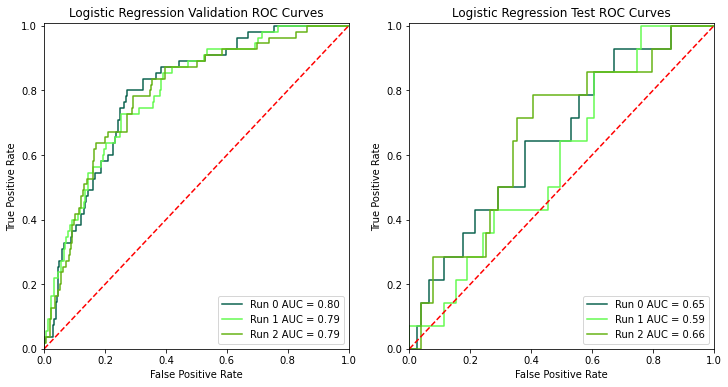

In [11]:
plot_auroc('logistic regression',lr_roc,3)

In [12]:
def sv_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

sv_space = {'model__C': hp.uniform('model__C', 0,500)}
sv_args = {'kernel': 'linear', 'probability': True}

sv_scores, sv_params, sv_idx, sv_roc = build_model(SVC, sv_space,
                                           sv_objective, scores, surgery,
                                           drop=to_drop['set_1'],
                                           return_idx=True, return_roc=True, **sv_args)

100%|██████████████████████████████████████████████████| 4/4 [02:34<00:00, 38.58s/trial, best loss: 0.3795093795093796]


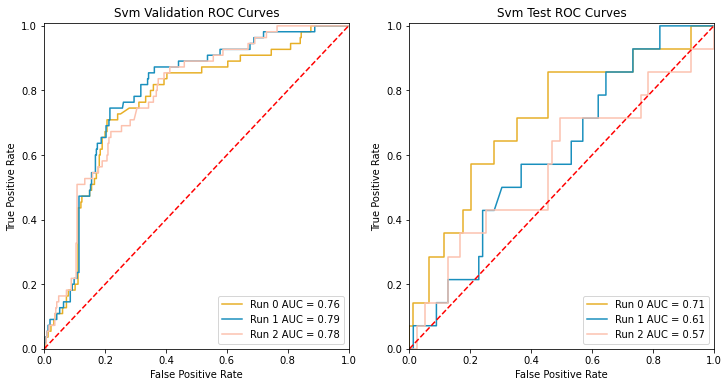

In [13]:
plot_auroc('SVM',sv_roc,3)

In [16]:
import lightgbm as lgb

def lg_objective(params, pipe, train_X, train_y, scoring):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

lg_space = {'model__n_estimators': hp.choice('model__n_estimators', range(20,80)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.001,0.35),
             'model__max_depth': hp.choice('model__max_depth', range(3,9)),
             'model__bagging_fraction ': hp.uniform('model__subsample', 0.7, 1.0),
             'model__lambda_l2': hp.uniform('model__lambda_l2', 0.1,21.0),
             'model__num_leaves': hp.choice('model__num_leaves',range(5,50)),
             'model__feature_fraction': hp.uniform('model__feature_fraction',0.6,1.0)}

cat_feats = list(range(2,11))+list(range(23,27))

lg_args = {'metric': 'binary_logloss', 'categorical_features': cat_feats,
           'early_stopping_rounds': 4}
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


lg_scores, lg_params, lg_idx, lg_roc = build_model(LGBMClassifier, lg_space, lg_objective,
                                       scores, surgery, drop=to_drop['set_1'], evals = 50,  
                                       return_idx=True, return_roc=True, **lg_args)

  4%|██▋                                                                | 2/50 [00:00<00:04, 11.59trial/s, best loss=?]

E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 61

  8%|█████▎                                                             | 4/50 [00:00<00:04, 11.37trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 12%|████████                                                           | 6/50 [00:00<00:03, 11.28trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 16%|██████████▋                                                        | 8/50 [00:00<00:03, 11.17trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 20%|█████████████▏                                                    | 10/50 [00:00<00:03, 11.07trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 24%|███████████████▊                                                  | 12/50 [00:01<00:03, 10.82trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 28%|██████████████████▍                                               | 14/50 [00:01<00:03, 10.70trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 32%|█████████████████████                                             | 16/50 [00:01<00:03, 10.62trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 36%|███████████████████████▊                                          | 18/50 [00:01<00:02, 10.67trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 40%|██████████████████████████▍                                       | 20/50 [00:01<00:02, 10.69trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 44%|█████████████████████████████                                     | 22/50 [00:02<00:02, 10.55trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 48%|███████████████████████████████▋                                  | 24/50 [00:02<00:02, 10.63trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 52%|██████████████████████████████████▎                               | 26/50 [00:02<00:02, 10.66trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 56%|████████████████████████████████████▉                             | 28/50 [00:02<00:02, 10.63trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 60%|███████████████████████████████████████▌                          | 30/50 [00:02<00:01, 10.61trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 64%|██████████████████████████████████████████▏                       | 32/50 [00:02<00:01, 10.61trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 68%|████████████████████████████████████████████▉                     | 34/50 [00:03<00:01, 10.56trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

 72%|███████████████████████████████████████████████▌                  | 36/50 [00:03<00:01, 10.62trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 76%|██████████████████████████████████████████████████▏               | 38/50 [00:03<00:01, 10.60trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 80%|████████████████████████████████████████████████████▊             | 40/50 [00:03<00:00, 10.55trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 84%|███████████████████████████████████████████████████████▍          | 42/50 [00:03<00:00, 10.49trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 88%|██████████████████████████████████████████████████████████        | 44/50 [00:04<00:00, 10.56trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 92%|████████████████████████████████████████████████████████████▋     | 46/50 [00:04<00:00, 10.54trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

 96%|███████████████████████████████████████████████████████████████▎  | 48/50 [00:04<00:00, 10.61trial/s, best loss=?]


E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py", line 262, in train
    cb(callback.CallbackEnv(model=booster,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.67trial/s, best loss=?]



E:\NYU\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\NYU\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "E:\NYU\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 6

AllTrialsFailed: 

In [ ]:
plot_auroc('LGBM',lg_roc,3)

In [17]:
def rf_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

rf_space = {'model__n_estimators': hp.choice('model__n_estimators', range(70,300)),
             'model__min_samples_leaf': hp.choice('model__min_samples_leaf',range(1,21)),
             'model__min_samples_split': hp.choice('model__min_samples_split',range(2,21)),
             'model__max_features': hp.uniform('model__max_features', 0.5, 0.9),
             'model__max_depth': hp.choice('model__max_depth', range(3,26))}

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


rf_scores, rf_params, rf_idx, rf_roc = build_model(RandomForestClassifier, rf_space, rf_objective,
                                       scores, surgery, drop=to_drop['set_1'], 
                                       return_idx=True, return_roc=True, scoring='accuracy')

100%|█████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/trial, best loss: 0.23513513513513506]


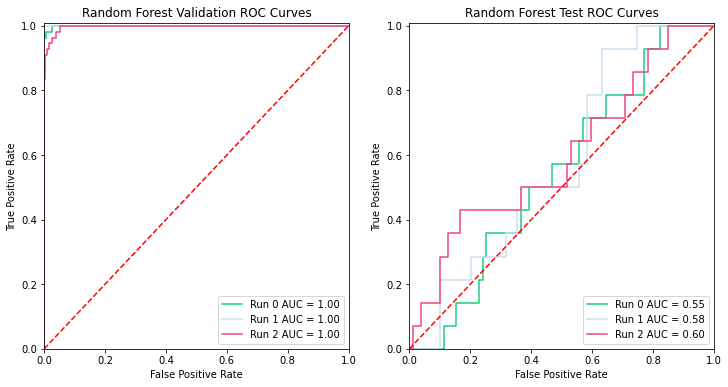

In [18]:
plot_auroc('Random Forest',rf_roc,3)

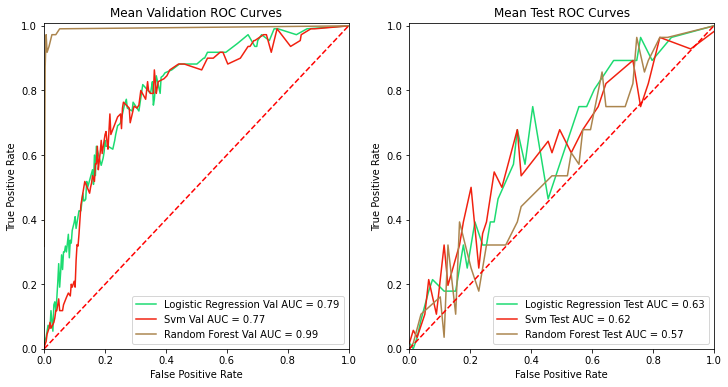

In [20]:
plot_aurocs(['Logistic Regression','SVM','Random Forest'],[lr_roc,sv_roc,rf_roc],[3,3,3])

## Model explainability

For this use case, the black box nature of machine learning models limits their practicality in informing decision-making. A doctor may know that a patient is at risk, but they also need to know *why* in order to prepare a treatment plan. Feature importance, being a global metric, does not suffice for this. We need to understand local importance; thus, model explainability through SHAP and LIME.

### SHAP

In [ ]:
# Code will for now be for a logistic regression. We'll update it with the best model later
# Use params and X_train of an average trial
import shap
lr_pipe = Pipeline([('upsample',ros),('model',LogisticRegression(max_iter=2000))])
lr_pipe.set_params(**lr_params[1])
X_train, X_test, y_train, y_test = split(surgery, idx=lr_idx[1])
lr_pipe.fit(X_train, y_train)

lr_explainer = shap.KernelExplainer(lr_pipe.predict_proba, X_test)
lr_shapvals = lr_explainer.shap_values(X_test)

shap.initjs()

In [ ]:
# The summary plot shows the SHAP value for each feature and for each
# instance, colored by magnitude of the feature
shap.summary_plot(lr_shapvals[1], X_test)

In [ ]:
# The dependence plot shows how a single feature's SHAP value
# depends on its magnitude. It is colored by whichever other
# feature the chosen one interacts most with

shap.dependence_plot('FEV1/FVC',lr_shapvals[1], X_test)
shap.dependence_plot('Tumor_size',lr_shapvals[1], X_test)

The force plot is our local explainability. Red wedges indicatethat that feature made our prediction more likely to be positive. Blue, the opposite. Wedge width corresponds to that feature's Shapley value. The middle value (bold black text) is what the model predicts; the model then transforms that prediction into a \[0,1\] probability space. Here, if that value is above 0.42660686, the model predicts a positive.

In [ ]:
lr_pipe.predict(X_test)

In [ ]:
lr_explainer.expected_value

In [ ]:
shap_values_0 = lr_explainer.shap_values(X_test.iloc[0,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_0[1], X_test.iloc[0,:])

In [ ]:
shap_values_1 = lr_explainer.shap_values(X_test.iloc[1,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_1[1], X_test.iloc[1,:])

Note how the most important feature for the negative example was FVC^2, but the most important for the positive example was FVC\*FEV1. This shows how local feature importance can be different from global feature importance.

Finally, the global force plot. Each point on the x-axis is essentially the above plot, but flipped vertical

In [ ]:
shap.force_plot(lr_explainer.expected_value[1], lr_shapvals[1], feature_names=X_test.columns)

### LIME

In [ ]:
# Use X_train, X_test, y_train, y_test from SHAP cells above

import lime
from lime import lime_tabular

# Perform LIME
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), 
                                                   mode='classification', feature_names = X_train.columns)

#### Positive example:

In [ ]:
# Show the results
lime_exp = lime_explainer.explain_instance(X_test.iloc[0], lr_pipe.predict_proba)
lime_exp.show_in_notebook(show_table=True, show_all=False)
lime_exp.as_pyplot_figure();

#### Negative example:

In [ ]:
lime_exp = lime_explainer.explain_instance(X_test.iloc[1], lr_pipe.predict_proba)
lime_exp.show_in_notebook(show_table=True, show_all=False)
lime_exp.as_pyplot_figure();